# 今回の取り組み

**Tyr50%でalbinoが検出されなかったので分類・クラスタリングの動作確認をする**

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [3]:
%%bash
# pipの更新
pip install -q -U pip
pip install -q -U -r requirements.txt

# 実験

## clusteringにmutation_lociを加える

In [8]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path
from importlib import reload

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report
from src.DAJIN2.core.clustering import clustering

reload(preprocess)
reload(classification)
reload(clustering)
reload(consensus)
reload(report)


#### #* 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "misc/data/tyr_albino_50%.fq.gz",
    "misc/data/tyr_control.fq.gz",
    "misc/data/tyr_control.fasta",
    "test-tyr-albino-50%",
    "mm10",
    True,
    14,
)
print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = min(THREADS, os.cpu_count()-1)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing test-tyr-albino-50%...


In [10]:

flag1 = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_control.jsonl").exists()
flag2 = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_control.jsonl").exists()
flag = flag1 and flag2

if not flag:
    print("preprocessing...")
    ################################################################################
    # Export fasta files as single-FASTA format
    ################################################################################
    for identifier, sequence in FASTA_ALLELES.items():
        contents = "\n".join([">" + identifier, sequence]) + "\n"
        output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
        output_fasta.write_text(contents)
    ###############################################################################
    # Mapping with mappy
    ###############################################################################
    for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
        name_fasta = path_fasta.stem
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
        )
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
        )
    ########################################################################
    # MIDSV conversion
    ########################################################################
    for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    ###############################################################################
    # CSSPLITS Error Correction
    ###############################################################################
    preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    ###############################################################################
    # Convert any `N` as deletions other than consecutive `N` from both ends
    ###############################################################################
    preprocess.replace_N_to_D.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
    preprocess.replace_N_to_D.execute(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
    ###############################################################################
    # Cashe inputs (control)
    ###############################################################################
    if not IS_CACHE_CONTROL:
        control_hash = Path(CONTROL).read_bytes()
        control_hash = hashlib.sha256(control_hash).hexdigest()
        PATH_CACHE_HASH = Path(TEMPDIR, "cache", "control_hash.txt")
        PATH_CACHE_HASH.write_text(str(control_hash))


preprocessing...


In [11]:
MUTATION_LOCI = preprocess.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)

In [12]:
MUTATION_LOCI.keys()

dict_keys(['control'])

In [13]:
########################################################################
# Classify alleles
########################################################################
print("Classify...")

classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)


Classify...


In [14]:
classif_sample[0]

{'QNAME': '00077750-d7ab-4c73-ac65-8707d39936c2',
 'RNAME': 'control',
 'CSSPLIT': '=T,=G,=C,=A,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=G,=A,=T,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,=G,=G,=C,=A,=A,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,=A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,=A,=G,=C,=T,=T,=A,=G,=C,=C,=A,=G,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,=T,=G,=T,=C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,=C,=

In [17]:
####################################################################################
# Clustering
####################################################################################
print("Clustering...")

clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS)
clust_sample = clustering.add_readnum(clust_sample)
clust_sample = clustering.add_percent(clust_sample)
clust_sample = clustering.update_labels(clust_sample)

Clustering...


In [19]:
count_labels = defaultdict(int)
for clust in clust_sample:
    count_labels[clust["LABEL"]] += 1

print(count_labels)

defaultdict(<class 'int'>, {1: 5000})


⬆⬆⬆ やはりクラスタリングされていない…

In [20]:
MUTATION_LOCI

defaultdict(set, {'control': {828}})

⬆⬆⬆ `MUTATION_LOCI`はきちんと変異部を抽出できている

### いちおう、828にある塩基をチェック

In [21]:
from DAJIN2.core.preprocess.correct_knockin import extract_knockin_loci
allele = "control"
mutation_loci = MUTATION_LOCI[allele]
knockin_alleles = extract_knockin_loci(TEMPDIR)

In [22]:
import midsv
# control
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Sample
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele]

In [25]:
count_mutation = defaultdict(int)
for cssplits in cssplits_control:
    count_mutation[cssplits[828]] += 1

print("control")
print(count_mutation)

control
defaultdict(<class 'int'>, {'=G': 9962, '-G': 13, '*GA': 7, 'N': 10, '*GT': 8})


In [26]:
count_mutation = defaultdict(int)
for cssplits in cssplits_sample:
    count_mutation[cssplits[828]] += 1

print("albino50%")
print(count_mutation)

albino50%
defaultdict(<class 'int'>, {'=G': 2504, '*GT': 2479, '*GA': 4, 'N': 7, '-G': 6})


⬆⬆⬆ `csspllits_sample`はきちんと変異部を抽出できている

### `clustering.py`を確認

In [27]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby
from pathlib import Path

import midsv

from DAJIN2.core.clustering.make_score import make_score
from DAJIN2.core.clustering.return_labels import return_labels
from DAJIN2.core.preprocess.correct_knockin import extract_knockin_loci


def extract_cssplits_in_mutation(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i, cs in enumerate(cssplits):
            if i in mutation_loci:
                cs_mutation.append(cs)
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation


def annotate_score(cssplits: list[list], mutation_score: list[dict]):
    scores = []
    for cssplit in cssplits:
        score = [0]
        for i in range(1, len(cssplit) - 1):
            if not mutation_score[i]:
                score.append(0)
                continue
            kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
            score.append(mutation_score[i].get(kmer, 0))
        scores.append(score + [0])
    return scores


def reorder_labels(labels: list[int], start: int = 0) -> list[int]:
    labels_ordered = labels.copy()
    num = start
    d = defaultdict(int)
    for i, l in enumerate(labels_ordered):
        if not d[l]:
            num += 1
            d[l] = num
        labels_ordered[i] = d[l]
    return labels_ordered


def compress_insertion(cssplits: list[list[str]]) -> list[dict[str, int]]:
    """
    Insertion will be subdivided by mutations in the its sequence, so it is compressed as a '+I' to eliminate mutations.
    """
    cssplits_abstracted = []
    for cssplit in cssplits:
        for i, cs in enumerate(cssplit):
            if cs.startswith("+"):
                cssplit[i] = "+I" + cs.split("|")[-1]
        cssplits_abstracted.append(cssplit)
    return cssplits_abstracted


def add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS: int = 1) -> list[dict[str]]:
    paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{CONTROL_NAME}_splice_*"))
    cssplits_control_by_alleles = defaultdict(list)
    for path_midsv in paths_midsv:
        midsv_control = midsv.read_jsonl(path_midsv)
        allele = path_midsv.stem.split("_")[-1]
        cssplits = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        cssplits_control_by_alleles[allele] = cssplits
    knockin_alleles = extract_knockin_loci(TEMPDIR)
    labels_all = []
    max_label = 0
    classif_sample.sort(key=lambda x: x["ALLELE"])
    for allele, group in groupby(classif_sample, key=lambda x: x["ALLELE"]):
        mutation_loci: set = MUTATION_LOCI[allele]
        cssplits_control = cssplits_control_by_alleles[allele]
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
        # cssplits_control = replace_both_ends_n(cssplits_control)
        # cssplits_sample = replace_both_ends_n(cssplits_sample)
        cssplits_control = extract_cssplits_in_mutation(cssplits_control, mutation_loci)
        cssplits_sample = extract_cssplits_in_mutation(cssplits_sample, mutation_loci)
        cssplits_control = compress_insertion(cssplits_control)
        cssplits_sample = compress_insertion(cssplits_sample)
        mutation_score = make_score(cssplits_control, cssplits_sample, knockin_alleles[allele])
        scores_control = annotate_score(cssplits_control, mutation_score)
        scores_sample = annotate_score(cssplits_sample, mutation_score)
        labels = return_labels(scores_sample, scores_control)
        labels_reorder = reorder_labels(labels, start=max_label)
        max_label = max(labels_reorder)
        labels_all.extend(labels_reorder)
    clust_sample = classif_sample.copy()
    for clust, label in zip(clust_sample, labels_all):
        clust["LABEL"] = label
    return clust_sample


def add_readnum(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    readnum = defaultdict(int)
    for cs in clust_result:
        readnum[cs["LABEL"]] += 1
    for cs in clust_result:
        cs["READNUM"] = readnum[cs["LABEL"]]
    return clust_result


def add_percent(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    n_sample = len(clust_result)
    percent = defaultdict(int)
    for cs in clust_result:
        percent[cs["LABEL"]] += 1 / n_sample
    percent = {key: round(val * 100, 3) for key, val in percent.items()}
    for cs in clust_result:
        cs["PERCENT"] = percent[cs["LABEL"]]
    return clust_result


def update_labels(clust_sample: list[dict]) -> list[dict]:
    """
    Allocate new labels according to the ranking by PERCENT
    """
    clust_result = clust_sample.copy()
    clust_result.sort(key=lambda x: (-x["PERCENT"], x["LABEL"]))
    new_label = 1
    prev_label = clust_result[0]["LABEL"]
    for cs in clust_result:
        if prev_label != cs["LABEL"]:
            new_label += 1
        prev_label = cs["LABEL"]
        cs["LABEL"] = new_label
    return clust_result


In [28]:
mutation_loci: set = MUTATION_LOCI[allele]
knockin_loci: set = knockin_alleles[allele]
# control
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Sample
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele]
cssplits_control = extract_cssplits_in_mutation(cssplits_control, mutation_loci)
cssplits_sample = extract_cssplits_in_mutation(cssplits_sample, mutation_loci)
cssplits_control = compress_insertion(cssplits_control)
cssplits_sample = compress_insertion(cssplits_sample)
mutation_score = make_score(cssplits_control, cssplits_sample, knockin_loci)
scores_control = annotate_score(cssplits_control, mutation_score)
scores_sample = annotate_score(cssplits_sample, mutation_score)

In [29]:
from collections import Counter
labels = return_labels(scores_sample, scores_control)
Counter(labels)

Counter({1: 5000})

In [32]:
mutation_score

[{}, {}]

⬆⬆⬆ `make_score`で空のmutation_scoreが返ってきている!?

In [33]:
print(knockin_alleles[allele])

set()


In [34]:
from __future__ import annotations

from collections import Counter, defaultdict


def call_count(cssplits: list[list[str]]) -> list[dict[str, int]]:
    """Count cssplits within 3-mer range.
    Args:
        cssplits (list[list[str]])
    Returns:
        list[dict[str, int]]: Both ends are counted as "N" to keep sequence length.
    """
    count_kmer = defaultdict(Counter)
    for cssplit in cssplits:
        for i in range(1, len(cssplit) - 1):
            kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
            count_kmer[i] += Counter([kmer])
    coverage = len(cssplits)
    count_score = [{"N,N,N": coverage}]
    count_score += [dict(count_kmer[i]) for i in range(1, len(cssplit) - 1)]
    count_score += [{"N,N,N": coverage}]
    return count_score


def call_percent(counts: list[dict[str:int]]) -> list[dict[str:float]]:
    cssplit_percent = []
    coverage = sum(counts[0].values())
    for count in counts:
        percent = {k: v / coverage * 100 for k, v in count.items()}
        cssplit_percent.append(percent)
    return cssplit_percent


def subtract_percentage(percent_control, percent_sample, knockin_loci) -> list[dict]:
    sample_subtracted = []
    for i, (cont, samp) in enumerate(zip(percent_control, percent_sample)):
        if i in knockin_loci:
            sample_subtracted.append(samp)
            continue
        samp = Counter(samp)
        samp.subtract(Counter(cont))
        sample_subtracted.append(dict(samp))
    return sample_subtracted


def discard_common_error(sample_subtracted, threshold=0.5):
    sample_discarded = []
    for samp in sample_subtracted:
        remained = {k: v for k, v in samp.items() if v > threshold}
        sample_discarded.append(remained)
    return sample_discarded


def discard_match(sample_subtracted):
    sample_discarded = []
    for samp in sample_subtracted:
        remained = {k: v for k, v in samp.items() if not k.split(",")[1].startswith("=")}
        sample_discarded.append(remained)
    return sample_discarded


###############################################################################
# main
###############################################################################


def make_score(cssplits_control, cssplits_sample, knockin_loci):
    counts_control = call_count(cssplits_control)
    counts_sample = call_count(cssplits_sample)
    percent_control = call_percent(counts_control)
    percent_sample = call_percent(counts_sample)
    percent_subtraction = subtract_percentage(percent_control, percent_sample, knockin_loci)
    percent_discarded = discard_common_error(percent_subtraction, 0.5)
    mutation_score = discard_match(percent_discarded)
    return mutation_score


In [36]:
knockin_loci: set = knockin_alleles[allele]
counts_control = call_count(cssplits_control)
counts_sample = call_count(cssplits_sample)
percent_control = call_percent(counts_control)
percent_sample = call_percent(counts_sample)
percent_subtraction = subtract_percentage(percent_control, percent_sample, knockin_loci)
percent_discarded = discard_common_error(percent_subtraction, 0.5)
mutation_score = discard_match(percent_discarded)

In [41]:
print(cssplits_control)
print(counts_sample)

[['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'],

In [39]:
print(percent_subtraction)
print(percent_discarded)
print(mutation_score)

[{'N,N,N': 0.0}, {'N,N,N': 0.0}]
[{}, {}]
[{}, {}]


⬆⬆⬆ `counts_sample`がめちゃくちゃ変

In [42]:
mutation_loci: set = MUTATION_LOCI[allele]
knockin_loci: set = knockin_alleles[allele]
# control
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Sample
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele]

In [45]:
cssplits_sample[0][:10]

['=T', '=G', '=C', '=A', '=T', '=T', '=G', '=A', '=A', '=G']

In [46]:
cssplits_extracted_control = extract_cssplits_in_mutation(cssplits_control, mutation_loci)
cssplits_extracted_sample = extract_cssplits_in_mutation(cssplits_sample, mutation_loci)

In [47]:
cssplits_extracted_sample

[['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT']

In [48]:
cssplits_compressed_control = compress_insertion(cssplits_extracted_control)
cssplits_compressed_sample = compress_insertion(cssplits_extracted_sample)

In [49]:
cssplits_compressed_sample

[['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['*GT'],
 ['=G'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT'],
 ['*GT']

In [52]:
mutation_score = make_score(cssplits_compressed_control, cssplits_compressed_sample, knockin_loci)

In [54]:
print(mutation_score)
print(cssplits_compressed_control)
print(cssplits_compressed_sample)

[{}, {}]
[['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G']

⬆⬆⬆ `make_score`には最低3つの塩基情報が必要なのに対して、今回のmutation_lociには1つの塩基しかないため想定外の結果となっている

- `mutation_score`を計算してから`mutation_loci`を抽出すれば良い

In [55]:
mutation_score = make_score(cssplits_control, cssplits_sample, knockin_loci)

In [56]:
print(len(mutation_score))

2845


In [57]:
print(mutation_loci)

{828}


In [59]:
def extract_score_in_mutation_loci(mutation_score, mutation_loci) -> list:
    """Extract score in mutation loci.
    Args:
        mutation_score (list[dict[str, float]]): Mutation score.
        mutation_loci (set[int]): Mutation loci.
    Returns:
        list[dict[str, float]]: Mutation score in mutation loci.
    """
    mutation_score_extracted = []
    for i, score in enumerate(mutation_score):
        if i in mutation_loci:
            mutation_score_extracted.append(score)
    return mutation_score_extracted

In [60]:
mutation_score = extract_score_in_mutation_loci(mutation_score, mutation_loci)

[{'=C,*GT,=T': 49.48}]

- `make_score`に`extract_score_in_mutation_loci`を追加
- `extract_cssplits_in_mutation`をコメントアウト

In [64]:
from __future__ import annotations

from collections import Counter, defaultdict


def call_count(cssplits: list[list[str]]) -> list[dict[str, int]]:
    """Count cssplits within 3-mer range.
    Args:
        cssplits (list[list[str]])
    Returns:
        list[dict[str, int]]: Both ends are counted as "N" to keep sequence length.
    """
    count_kmer = defaultdict(Counter)
    for cssplit in cssplits:
        for i in range(1, len(cssplit) - 1):
            kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
            count_kmer[i] += Counter([kmer])
    coverage = len(cssplits)
    count_score = [{"N,N,N": coverage}]
    count_score += [dict(count_kmer[i]) for i in range(1, len(cssplit) - 1)]
    count_score += [{"N,N,N": coverage}]
    return count_score


def call_percent(counts: list[dict[str:int]]) -> list[dict[str:float]]:
    cssplit_percent = []
    coverage = sum(counts[0].values())
    for count in counts:
        percent = {k: v / coverage * 100 for k, v in count.items()}
        cssplit_percent.append(percent)
    return cssplit_percent


def subtract_percentage(percent_control, percent_sample, knockin_loci) -> list[dict]:
    sample_subtracted = []
    for i, (cont, samp) in enumerate(zip(percent_control, percent_sample)):
        if i in knockin_loci:
            sample_subtracted.append(samp)
            continue
        samp = Counter(samp)
        samp.subtract(Counter(cont))
        sample_subtracted.append(dict(samp))
    return sample_subtracted


def discard_common_error(sample_subtracted, threshold=0.5):
    sample_discarded = []
    for samp in sample_subtracted:
        remained = {k: v for k, v in samp.items() if v > threshold}
        sample_discarded.append(remained)
    return sample_discarded


def discard_match(sample_subtracted):
    sample_discarded = []
    for samp in sample_subtracted:
        remained = {k: v for k, v in samp.items() if not k.split(",")[1].startswith("=")}
        sample_discarded.append(remained)
    return sample_discarded


def extract_score_in_mutation_loci(mutation_score, mutation_loci) -> list:
    """Extract score in mutation loci.
    Args:
        mutation_score (list[dict[str, float]]): Mutation score.
        mutation_loci (set[int]): Mutation loci.
    Returns:
        list[dict[str, float]]: Mutation score in mutation loci.
    """
    mutation_score_extracted = []
    for i, score in enumerate(mutation_score):
        if i in mutation_loci:
            mutation_score_extracted.append(score)
    return mutation_score_extracted


###############################################################################
# main
###############################################################################


def make_score(cssplits_control, cssplits_sample, knockin_loci, mutation_loci) -> list[dict[str, float]]:
    counts_control = call_count(cssplits_control)
    counts_sample = call_count(cssplits_sample)
    percent_control = call_percent(counts_control)
    percent_sample = call_percent(counts_sample)
    percent_subtraction = subtract_percentage(percent_control, percent_sample, knockin_loci)
    percent_discarded = discard_common_error(percent_subtraction, 0.5)
    mutation_score = discard_match(percent_discarded)
    mutation_score = extract_score_in_mutation_loci(mutation_score, mutation_loci)
    return mutation_score


In [61]:
counts_control = call_count(cssplits_control)
counts_sample = call_count(cssplits_sample)
percent_control = call_percent(counts_control)
percent_sample = call_percent(counts_sample)
percent_subtraction = subtract_percentage(percent_control, percent_sample, knockin_loci)
percent_discarded = discard_common_error(percent_subtraction, 0.5)
mutation_score = discard_match(percent_discarded)
mutation_score = extract_score_in_mutation_loci(mutation_score, mutation_loci)

In [62]:
print(mutation_score)

[{'=C,*GT,=T': 49.48}]


In [67]:
mutation_loci: set = MUTATION_LOCI[allele]
knockin_loci: set = knockin_alleles[allele]
# control
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Sample
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele]

cssplits_control = compress_insertion(cssplits_control)
cssplits_sample = compress_insertion(cssplits_sample)
mutation_score = make_score(cssplits_control, cssplits_sample, knockin_loci, mutation_loci)
scores_control = annotate_score(cssplits_control, mutation_score)
scores_sample = annotate_score(cssplits_sample, mutation_score)
labels = return_labels(scores_sample, scores_control)

IndexError: list index out of range

In [68]:
def annotate_score(cssplits: list[list], mutation_loci:set, mutation_score: list[dict]):
    scores = []
    for cssplit in cssplits:
        score = [0]
        for i in range(1, len(cssplit) - 1):
            if not i in mutation_loci:
                score.append(0)
                continue
            kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
            score.append(mutation_score[i].get(kmer, 0))
        scores.append(score + [0])
    return scores


In [69]:
scores_control = annotate_score(cssplits_control, mutation_loci, mutation_score)

IndexError: list index out of range

⬆⬆⬆
- `3mer`縛りが面倒くさいのと、なるべく早めから計算量を抑えたい
- cssplitsを抽出する時点で3merにする

In [ ]:
def extract_cssplits_in_mutation_by_3mer(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i, cs in enumerate(cssplits):
            if i in mutation_loci:
                cs_mutation.append(cs)
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation


In [70]:
def extract_cssplits_in_mutation(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i, cs in enumerate(cssplits):
            if i in mutation_loci:
                cs_mutation.append(cs)
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation


In [71]:
x = extract_cssplits_in_mutation(cssplits_sample, mutation_loci)

In [72]:
print(x)

[['=G'], ['*GT'], ['=G'], ['*GT'], ['=G'], ['*GT'], ['=G'], ['=G'], ['*GT'], ['=G'], ['*GT'], ['*GT'], ['=G'], ['*GT'], ['=G'], ['*GT'], ['=G'], ['=G'], ['=G'], ['*GT'], ['=G'], ['*GT'], ['=G'], ['=G'], ['*GT'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['*GT'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['*GT'], ['*GT'], ['=G'], ['*GT'], ['=G'], ['*GT'], ['*GT'], ['*GT'], ['*GT'], ['*GT'], ['*GT'], ['=G'], ['=G'], ['=G'], ['*GT'], ['=G'], ['=G'], ['*GT'], ['=G'], ['*GT'], ['=G'], ['=G'], ['=G'], ['*GT'], ['*GT'], ['*GT'], ['*GT'], ['*GT'], ['*GT'], ['=G'], ['=G'], ['=G'], ['*GT'], ['*GT'], ['*GT'], ['=G'], ['*GT'], ['=G'], ['=G'], ['=G'], ['=G'], ['=G'], ['*GT'], ['*GT'], ['*GT'], ['*GT'], ['=G'], ['=G'], ['=G'], ['=G'], ['*GT'], ['=G'], ['*GT'], ['=G'], ['*GT'], ['*GT'], ['=G'], ['*GT'], ['*GT'], ['*GT'], ['*GT'], ['*GT'], ['*GT'], ['=G'], ['*GT'], ['=G'], ['=G'], ['*GT'], ['*GT'], ['=G'], ['*GT'], ['=G'], ['*GT'], ['*GT'], ['*GT'], 

In [73]:
def extract_cssplits_in_mutation_by_3mer(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i in range(1, len(cssplits) - 1):
            if i in mutation_loci:
                kmer = ",".join([cssplits[i - 1], cssplits[i], cssplits[i + 1]])
                cs_mutation.append(kmer)
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation

In [74]:
y = extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)

In [75]:
print(y)

[['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,*

In [76]:
from __future__ import annotations

from collections import Counter, defaultdict


def call_count(cssplits: list[list[str]]) -> list[dict[str, int]]:
    """Count cssplits within 3-mer range.
    Args:
        cssplits (list[list[str]])
    Returns:
        list[dict[str, int]]: Both ends are counted as "N" to keep sequence length.
    """
    count_kmer = defaultdict(Counter)
    for cssplit in cssplits:
        for i in range(1, len(cssplit) - 1):
            kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
            count_kmer[i] += Counter([kmer])
    coverage = len(cssplits)
    count_score = [{"N,N,N": coverage}]
    count_score += [dict(count_kmer[i]) for i in range(1, len(cssplit) - 1)]
    count_score += [{"N,N,N": coverage}]
    return count_score


def call_percent(counts: list[dict[str:int]]) -> list[dict[str:float]]:
    cssplit_percent = []
    coverage = sum(counts[0].values())
    for count in counts:
        percent = {k: v / coverage * 100 for k, v in count.items()}
        cssplit_percent.append(percent)
    return cssplit_percent


def subtract_percentage(percent_control, percent_sample, knockin_loci) -> list[dict]:
    sample_subtracted = []
    for i, (cont, samp) in enumerate(zip(percent_control, percent_sample)):
        if i in knockin_loci:
            sample_subtracted.append(samp)
            continue
        samp = Counter(samp)
        samp.subtract(Counter(cont))
        sample_subtracted.append(dict(samp))
    return sample_subtracted


def discard_common_error(sample_subtracted, threshold=0.5):
    sample_discarded = []
    for samp in sample_subtracted:
        remained = {k: v for k, v in samp.items() if v > threshold}
        sample_discarded.append(remained)
    return sample_discarded


def discard_match(sample_subtracted):
    sample_discarded = []
    for samp in sample_subtracted:
        remained = {k: v for k, v in samp.items() if not k.split(",")[1].startswith("=")}
        sample_discarded.append(remained)
    return sample_discarded


# def extract_score_in_mutation_loci(mutation_score, mutation_loci) -> list:
#     """Extract score in mutation loci.
#     Args:
#         mutation_score (list[dict[str, float]]): Mutation score.
#         mutation_loci (set[int]): Mutation loci.
#     Returns:
#         list[dict[str, float]]: Mutation score in mutation loci.
#     """
#     mutation_score_extracted = []
#     for i, score in enumerate(mutation_score):
#         if i in mutation_loci:
#             mutation_score_extracted.append(score)
#     return mutation_score_extracted


###############################################################################
# main
###############################################################################


def make_score(cssplits_control, cssplits_sample, knockin_loci) -> list[dict[str, float]]:
    counts_control = call_count(cssplits_control)
    counts_sample = call_count(cssplits_sample)
    percent_control = call_percent(counts_control)
    percent_sample = call_percent(counts_sample)
    percent_subtraction = subtract_percentage(percent_control, percent_sample, knockin_loci)
    percent_discarded = discard_common_error(percent_subtraction, 0.5)
    mutation_score = discard_match(percent_discarded)
    # mutation_score = extract_score_in_mutation_loci(mutation_score, mutation_loci)
    return mutation_score


In [77]:
mutation_loci: set = MUTATION_LOCI[allele]
knockin_loci: set = knockin_alleles[allele]
# control
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Sample
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele]

cssplits_control = compress_insertion(cssplits_control)
cssplits_sample = compress_insertion(cssplits_sample)
cssplits_control = extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
cssplits_sample = extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
mutation_score = make_score(cssplits_control, cssplits_sample, knockin_loci)
scores_control = annotate_score(cssplits_control, mutation_score)
scores_sample = annotate_score(cssplits_sample, mutation_score)
labels = return_labels(scores_sample, scores_control)

TypeError: annotate_score() missing 1 required positional argument: 'mutation_score'

In [80]:
print(cssplits_sample)

[['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,=G,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,*GT,=T'], ['=C,*

## clustering.add_labelの処理順番と内容を以下のように変更
- 変異部のみを抽出するコードは計算量低減のために早めに行いたいので、`compress_insertion`のあとに`extract_cssplits_in_mutation_by_3mer`を噛ませる
- `make_score`や`annotate_score`は、3merの処理が入るけれどもそれに依存しない（1merだったり5merだったりしても動く）ようなコードにする
- `knockin_loci`の処理はひとまず後回しにする
  - なんで必要なのか理由を忘れたから…

In [82]:
mutation_loci: set = MUTATION_LOCI[allele]
knockin_loci: set = knockin_alleles[allele]
# control
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Sample
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele]

cssplits_control = compress_insertion(cssplits_control)
cssplits_sample = compress_insertion(cssplits_sample)

In [83]:
def extract_cssplits_in_mutation_by_3mer(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i in range(1, len(cssplits) - 1):
            if i in mutation_loci:
                kmer = ",".join([cssplits[i - 1], cssplits[i], cssplits[i + 1]])
                cs_mutation.append(kmer)
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation


In [84]:
cssplits_control = extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
cssplits_sample = extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)

In [85]:
from __future__ import annotations

from collections import Counter, defaultdict


def call_count(cssplits: list[list[str]]) -> list[dict[str, int]]:
    """Count cssplits within 3-mer range.
    Args:
        cssplits (list[list[str]])
    Returns:
        list[dict[str, int]]: Both ends are counted as "N" to keep sequence length.
    """
    count_kmer = defaultdict(Counter)
    for cssplit in cssplits:
        for i in range(1, len(cssplit) - 1):
            kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
            count_kmer[i] += Counter([kmer])
    coverage = len(cssplits)
    count_score = [{"N,N,N": coverage}]
    count_score += [dict(count_kmer[i]) for i in range(1, len(cssplit) - 1)]
    count_score += [{"N,N,N": coverage}]
    return count_score


def call_percent(counts: list[dict[str:int]]) -> list[dict[str:float]]:
    cssplit_percent = []
    coverage = sum(counts[0].values())
    for count in counts:
        percent = {k: v / coverage * 100 for k, v in count.items()}
        cssplit_percent.append(percent)
    return cssplit_percent


def subtract_percentage(percent_control, percent_sample) -> list[dict]:
    sample_subtracted = []
    for cont, samp in zip(percent_control, percent_sample):
        samp = Counter(samp)
        samp.subtract(Counter(cont))
        sample_subtracted.append(dict(samp))
    return sample_subtracted


# def subtract_percentage(percent_control, percent_sample, knockin_loci) -> list[dict]:
#     sample_subtracted = []
#     for i, (cont, samp) in enumerate(zip(percent_control, percent_sample)):
#         if i in knockin_loci:
#             sample_subtracted.append(samp)
#             continue
#         samp = Counter(samp)
#         samp.subtract(Counter(cont))
#         sample_subtracted.append(dict(samp))
#     return sample_subtracted


def discard_common_error(sample_subtracted, threshold=0.5) -> list[dict]:
    sample_discarded = []
    for samp in sample_subtracted:
        remained = {k: v for k, v in samp.items() if v > threshold}
        sample_discarded.append(remained)
    return sample_discarded


def discard_match(sample_subtracted) -> list[dict]:
    sample_discarded = []
    for samp in sample_subtracted:
        remained = {k: v for k, v in samp.items() if not k.split(",")[1].startswith("=")}
        sample_discarded.append(remained)
    return sample_discarded


# def extract_score_in_mutation_loci(mutation_score, mutation_loci) -> list:
#     """Extract score in mutation loci.
#     Args:
#         mutation_score (list[dict[str, float]]): Mutation score.
#         mutation_loci (set[int]): Mutation loci.
#     Returns:
#         list[dict[str, float]]: Mutation score in mutation loci.
#     """
#     mutation_score_extracted = []
#     for i, score in enumerate(mutation_score):
#         if i in mutation_loci:
#             mutation_score_extracted.append(score)
#     return mutation_score_extracted


###############################################################################
# main
###############################################################################


def make_score(cssplits_control, cssplits_sample, knockin_loci) -> list[dict[str, float]]:
    counts_control = call_count(cssplits_control)
    counts_sample = call_count(cssplits_sample)
    percent_control = call_percent(counts_control)
    percent_sample = call_percent(counts_sample)
    percent_subtraction = subtract_percentage(percent_control, percent_sample)
    percent_discarded = discard_common_error(percent_subtraction, 0.5)
    mutation_score = discard_match(percent_discarded)
    return mutation_score


In [86]:
mutation_score = make_score(cssplits_control, cssplits_sample, knockin_loci)

In [90]:
print(mutation_score)

[{}, {}]


In [91]:
counts_control = call_count(cssplits_control)
counts_sample = call_count(cssplits_sample)
percent_control = call_percent(counts_control)
percent_sample = call_percent(counts_sample)
percent_subtraction = subtract_percentage(percent_control, percent_sample)
percent_discarded = discard_common_error(percent_subtraction, 0.5)
mutation_score = discard_match(percent_discarded)

In [102]:
def call_count(cssplits: list[list[str]]) -> list[dict[str, int]]:
    count_kmer = []
    for cs in list(zip(*cssplits)):
        count_kmer.append(dict(Counter(cs)))
    return count_kmer

In [104]:
counts_control = call_count(cssplits_control)
counts_sample = call_count(cssplits_sample)
print(counts_control)
print(counts_sample)

[{'=C,=G,=T': 9943, '-C,-G,-T': 13, '=C,*GA,=T': 7, 'N,N,N': 10, '*CT,=G,=T': 8, '=C,*GT,=T': 8, '=C,=G,*TC': 5, '=C,=G,*TA': 2, '*CT,=G,*TA': 1, '*CT,=G,*TG': 1, '*CG,=G,=T': 1, '*CA,=G,=T': 1}]
[{'=C,=G,=T': 2495, '=C,*GT,=T': 2478, '=C,*GA,=T': 4, 'N,N,N': 7, '=C,=G,*TC': 4, '=C,*GT,*TA': 1, '-C,-G,-T': 6, '*CT,=G,=T': 2, '=C,=G,*TA': 1, '*CG,=G,=T': 1, '*CA,=G,=T': 1}]


In [105]:
percent_control = call_percent(counts_control)
percent_sample = call_percent(counts_sample)
percent_subtraction = subtract_percentage(percent_control, percent_sample)
percent_discarded = discard_common_error(percent_subtraction, 0.5)
mutation_score = discard_match(percent_discarded)
print(percent_control)
print(percent_sample)
print(percent_subtraction)

[{'=C,=G,=T': 99.42999999999999, '-C,-G,-T': 0.13, '=C,*GA,=T': 0.06999999999999999, 'N,N,N': 0.1, '*CT,=G,=T': 0.08, '=C,*GT,=T': 0.08, '=C,=G,*TC': 0.05, '=C,=G,*TA': 0.02, '*CT,=G,*TA': 0.01, '*CT,=G,*TG': 0.01, '*CG,=G,=T': 0.01, '*CA,=G,=T': 0.01}]
[{'=C,=G,=T': 49.9, '=C,*GT,=T': 49.559999999999995, '=C,*GA,=T': 0.08, 'N,N,N': 0.13999999999999999, '=C,=G,*TC': 0.08, '=C,*GT,*TA': 0.02, '-C,-G,-T': 0.12, '*CT,=G,=T': 0.04, '=C,=G,*TA': 0.02, '*CG,=G,=T': 0.02, '*CA,=G,=T': 0.02}]
[{'=C,=G,=T': -49.529999999999994, '=C,*GT,=T': 49.48, '=C,*GA,=T': 0.010000000000000009, 'N,N,N': 0.03999999999999998, '=C,=G,*TC': 0.03, '=C,*GT,*TA': 0.02, '-C,-G,-T': -0.010000000000000009, '*CT,=G,=T': -0.04, '=C,=G,*TA': 0.0, '*CG,=G,=T': 0.01, '*CA,=G,=T': 0.01, '*CT,=G,*TA': -0.01, '*CT,=G,*TG': -0.01}]


In [106]:
print(percent_discarded)

[{'=C,*GT,=T': 49.48}]


In [107]:
print(mutation_score)

[{'=C,*GT,=T': 49.48}]


In [173]:
def annotate_score(cssplits: list[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = []
        for cs, mutscore in zip(cssplit, mutation_score):
            mutation = list(mutscore.keys())[0]
            value = list(mutscore.values())[0]
            if cs == mutation:
                score.append(value)
            else:
                score.append(0)
        scores.append(score)
    return scores

In [174]:
print(len(cssplits_control[0]), len(mutation_score))

1 1


In [175]:
annotate_score(cssplits_sample, mutation_score)[:5]

[[0], [49.48], [0], [49.48], [0]]

In [176]:
scores_control = annotate_score(cssplits_control, mutation_score)
scores_sample = annotate_score(cssplits_sample, mutation_score)
labels = return_labels(scores_sample, scores_control)

In [177]:
Counter(labels)

Counter({4: 2522, 3: 2478})

## DONE: clustering.add_labelの処理順番と内容を以下のように変更
- 変異部のみを抽出するコードは計算量低減のために早めに行いたいので、`compress_insertion`のあとに`extract_cssplits_in_mutation_by_3mer`を噛ませる
- `make_score`や`annotate_score`は、3merの処理が入るけれどもそれに依存しない（1merだったり5merだったりしても動く）ようなコードにする
- `knockin_loci`の処理はひとまず後回しにする
  - なんで必要なのか理由を忘れたから…

ということで、動くかテストします

In [183]:
!rm -rf DAJINResults/test-single DAJINResults/.tempdir/test-single

In [184]:
%%bash
pip install -qe .
DAJIN2 \
    --name test-single \
    --control misc/data/tyr_control.fq.gz \
    --sample misc/data/tyr_albino_50%.fq.gz \
    --allele misc/data/tyr_control.fasta \
    --genome mm10

Traceback (most recent call last):
  File "/home/kuno/miniconda/bin/DAJIN2", line 33, in <module>
    sys.exit(load_entry_point('DAJIN2', 'console_scripts', 'DAJIN2')())
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 94, in main
    single.single_execute(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/single.py", line 12, in single_execute
    core_execute.execute_sample(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/core_execute.py", line 110, in execute_sample
    preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/preprocess/correct_sequence_error.py", line 177, in execute
    midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl"))
  File "/home/kuno/miniconda/lib/python3.10/site-packages/midsv/io.py", line 30, in write_jsonl
    with open(filepath, "w") as output:
FileNotFoundError: [Errno 2] No such file or directory: 'DAJINRes

ばっちりでした！


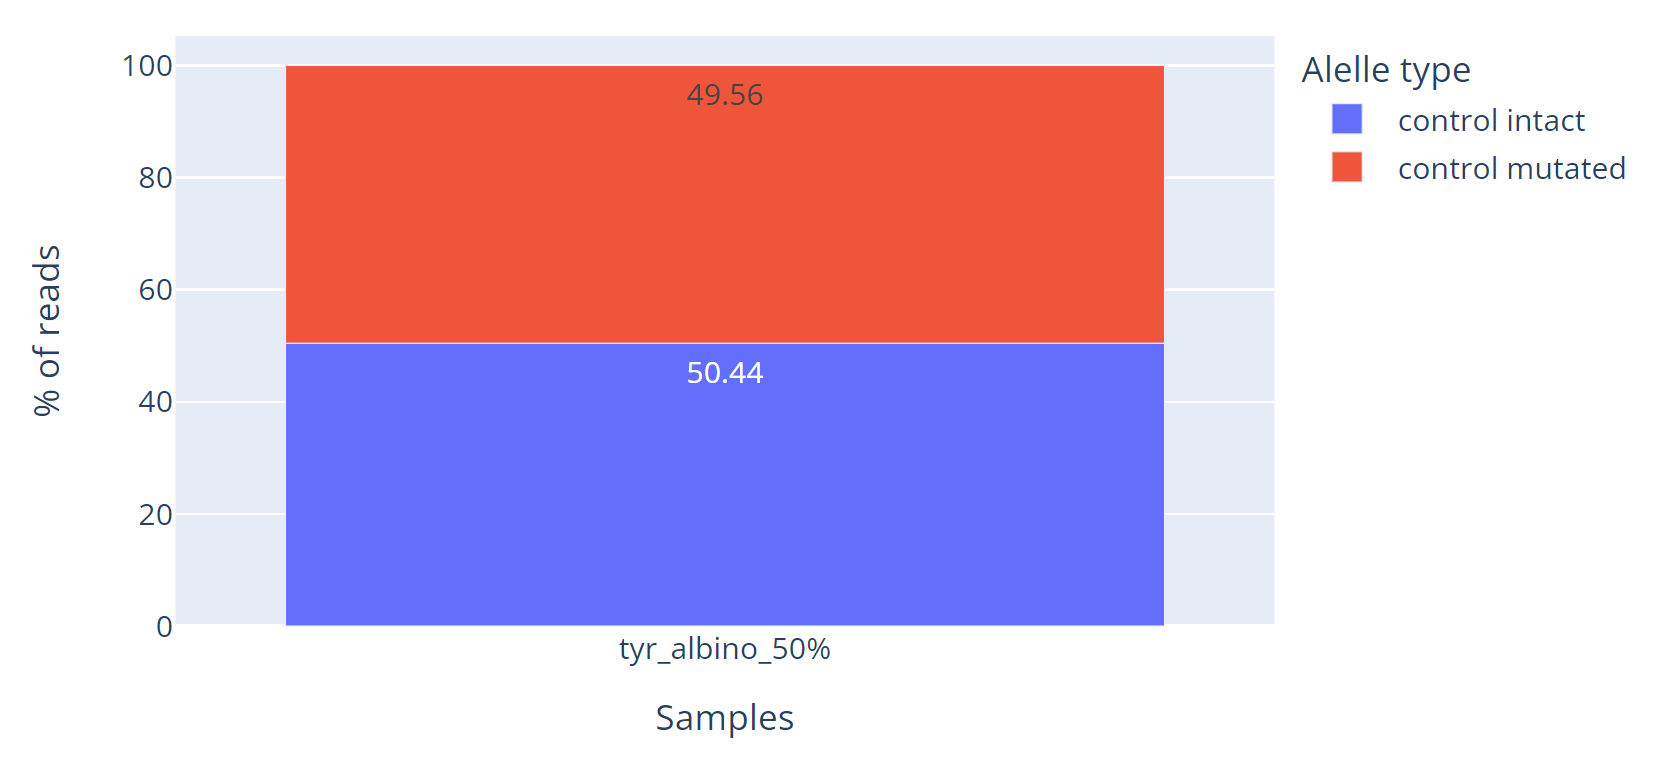

- 次は10%と01%もチェックします

In [185]:
!rm -rf DAJINResults/tyr-DAJIN2 DAJINResults/.tempdir/tyr-DAJIN2

In [186]:
!pip install -qe . && DAJIN2 batch -f misc/data/design-dajin2.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...
misc/data/tyr_albino_10%.fq.gz is now processing...
misc/data/tyr_albino_01%.fq.gz is now processing...
Finished! Open DAJINResults/tyr-DAJIN2 to see the report.


- 10%, 01%ともにひどい結果になりました…！
- 次回の課題です。。。

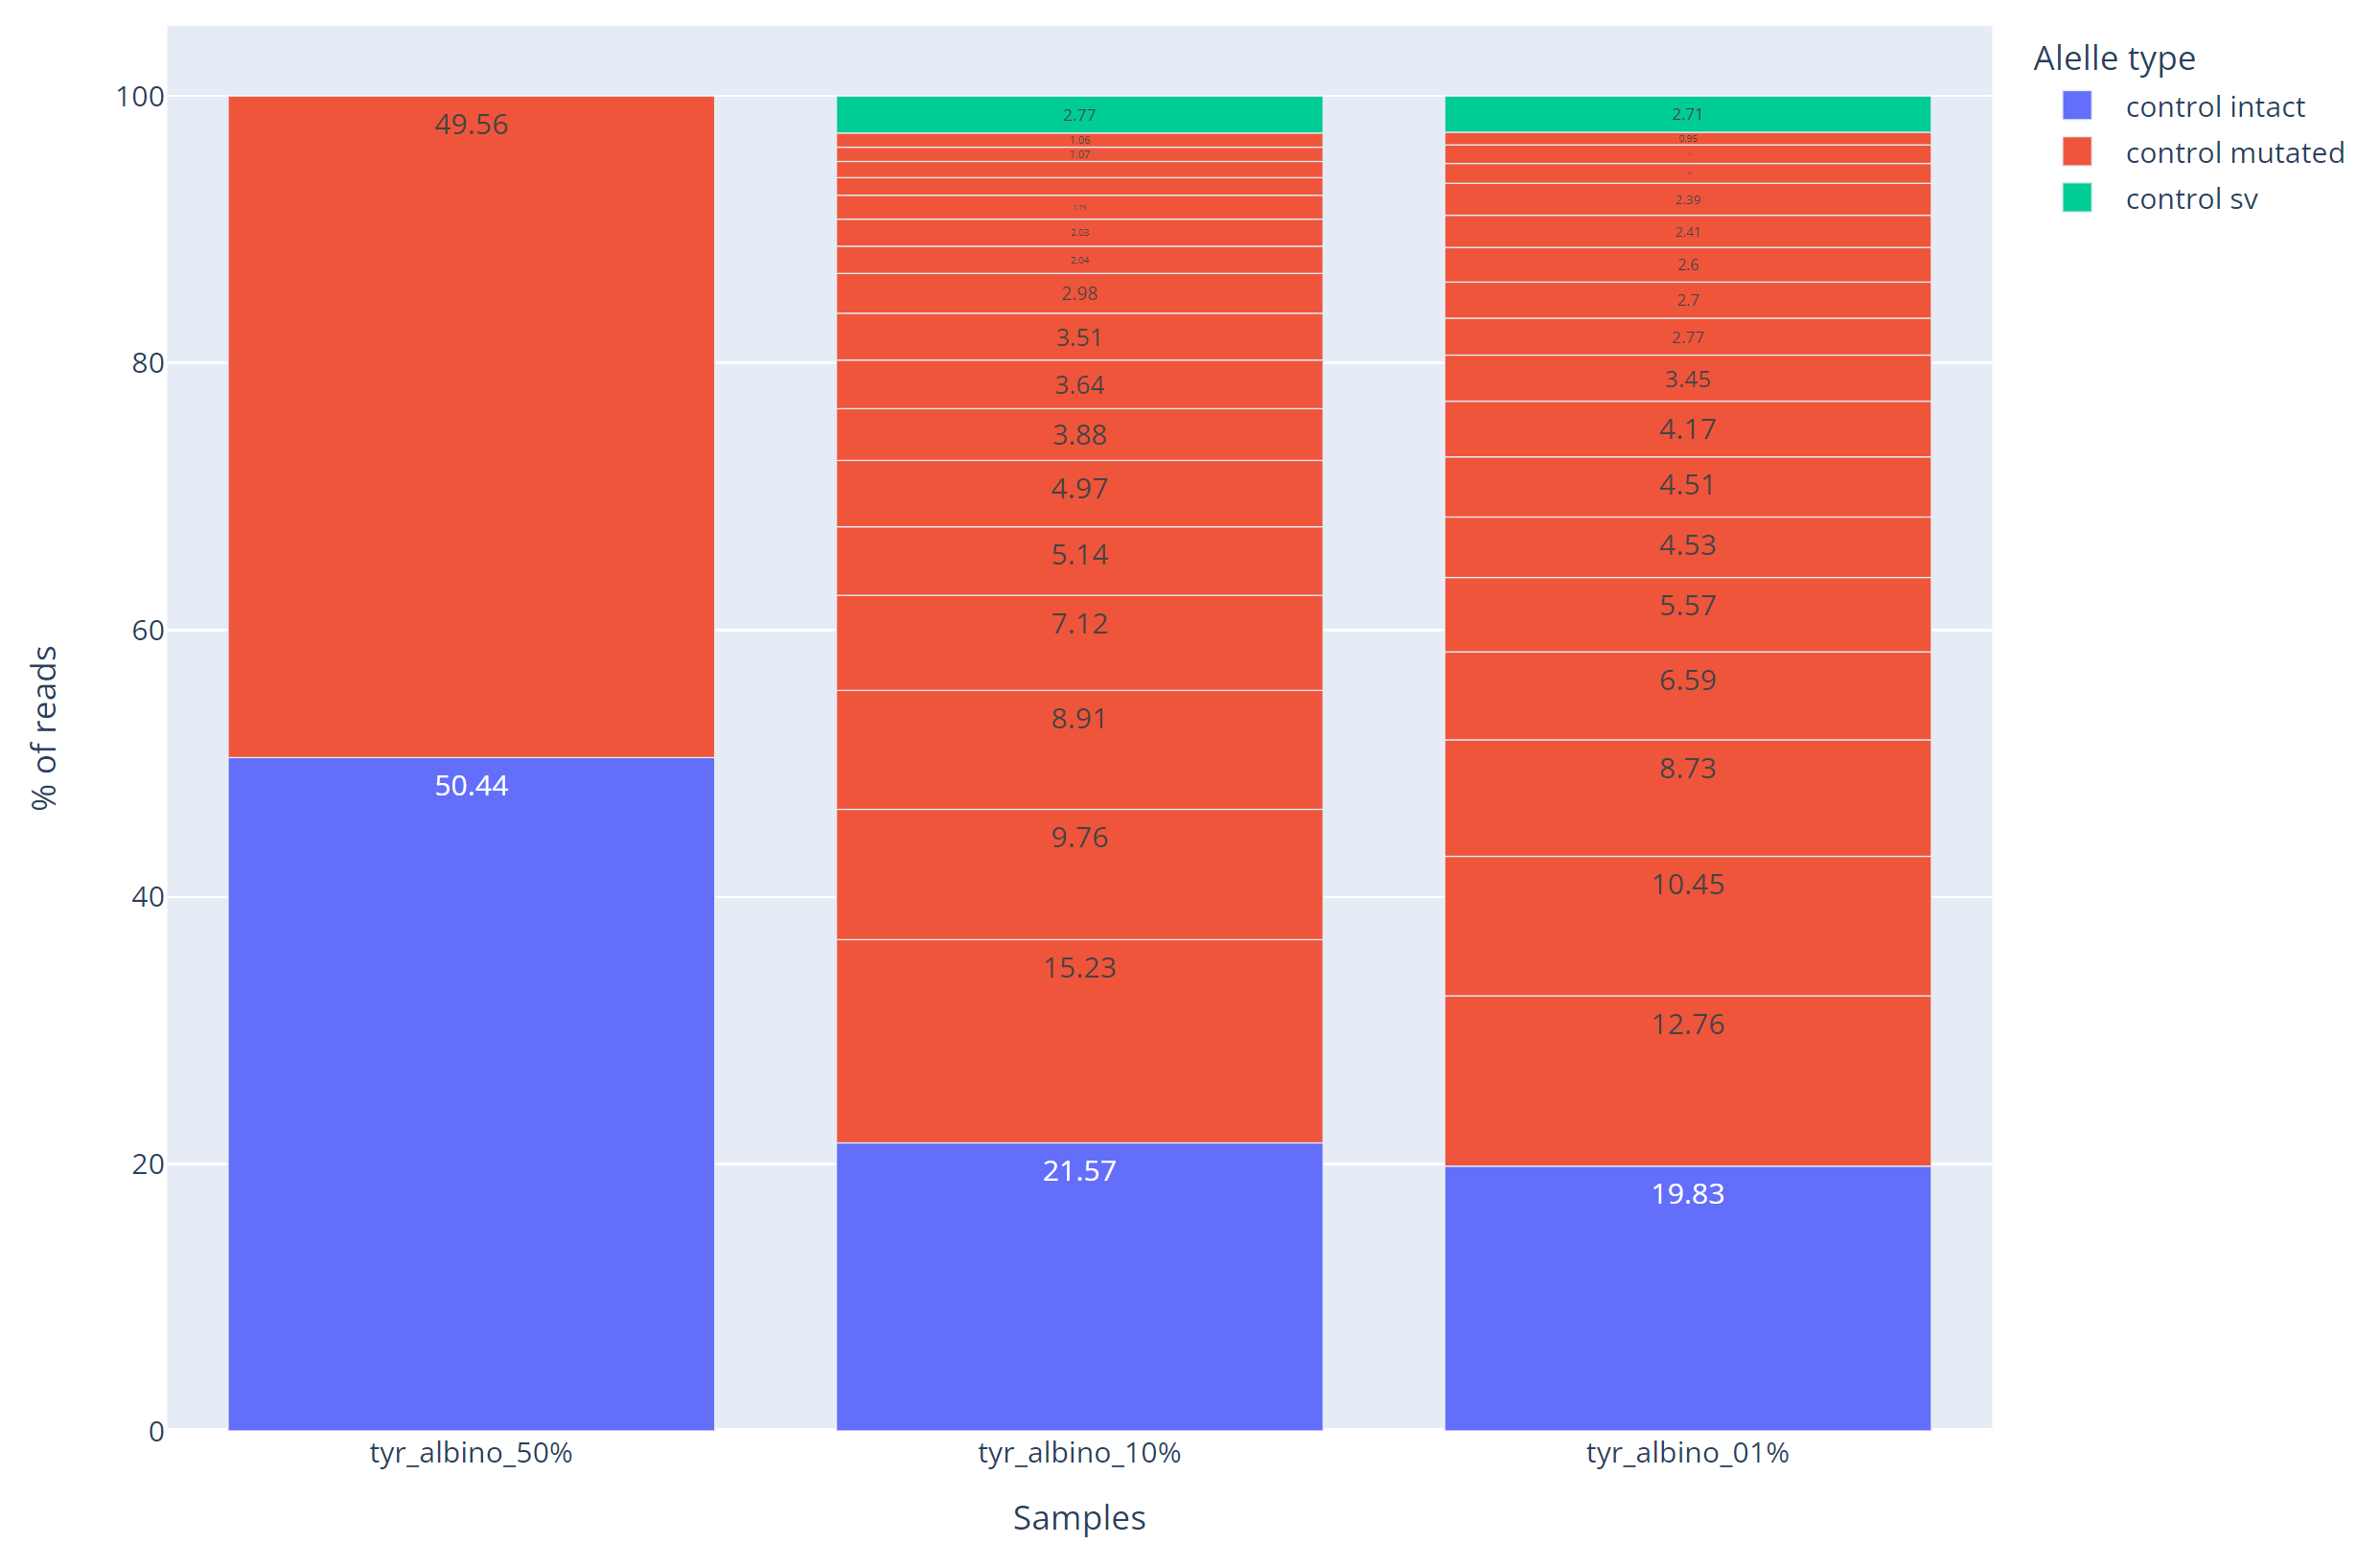

# まとめ


- `compress_insertion`のあとに`extract_cssplits_in_mutation_by_3mer`を入れました
- `make_score`や`annotate_score`を書き換えて、3merの処理が入るけれどもそれに依存しない形式にしました
    - 1merだったり5merだったりしても動くようなコードにしました

- tyr_50%はうまくいきましたが、10%や01%では細分化されすぎていてだめな感じになりました
    - どうやら目的とする変異自体も見つけられていないようです…
    - 次回検討します

# 次に取り組むこと

### Lists

+ **tyr_10%, 01%でうまくいかなかった理由を検討する**

+ [ ] 短いリードの扱いをどうするべきか
+ [ ] `SV`の判定をconsensus callのあとにする
+ [ ] cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`clustering.replace_both_ends_n`）
+ [ ] Insertionのなかにある変異を同定する手法を考案する
+ [ ] Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ [ ] `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする